# 3. Unsupervised Analysis

Once medieval texts are converted to a numerical format, the ensuing ways to manipulate and analyse them are numerous. In general, two general approaches can be discerned, parallel to a classic data-scientific distinction, (a) non-supervised and (b) supervised. The latter will be subject of our next notebook.

Unsupervised methods allow to inspect data and enable a detection of trends on an **exploratory** basis. As opposed to supervised learning, it needs no labelled training input in order to be operational. Its aim is to describe without prescience, not to classify. By implication, the general disadvantage of unsupervised methods is that there is limited possibility of evaluation (a degree-of-error) for each observation, nor can it give estimations of which features are redundant for certain questions. Therefore, practitioners strongly advise to back up unsupervised analysis with supervised evidence when that proves feasible.

Examples of unsupervised techniques applied to medieval texts are numerous. Popularly used are **principal components analysis** or **PCA** (Kestemont et al. 2015), ***k* nearest neighbours** (sometimes visualized with network analysis; e.g. Eder 2016:72), **t-distributed stochastic neighbor embedding** or t-SNE (Leclercq and Kestemont 2021:229) and **dendrogram analysis** (e.g. Dockray-Miller et al. 2021).

Before we proceed, we **repeat**, with the block of code below, **the steps from the previous notebook.**

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from string import punctuation
import glob
import numpy as np
import os
import pandas as pd
import re

current_directory = os.getcwd() # gets current directory
folder_path = current_directory + '/corpus/train' # gets directory path to corpus folder containing .txt files

# Declare empty lists to fill up with our metadata and data
authors = []
titles = []
texts = []

# We declare some parameters — the 'settings' of our stylometric experiments
sample_len = 5000 # word length of text segment

# Open all file objects in folder and gather data
for filename in glob.glob(folder_path + '/*'):
    author = filename.split("/")[-1].split(".")[0].split("_")[0]
    title = filename.split("/")[-1].split(".")[0].split("_")[1]

    bulk = []
    text = open(filename, encoding='utf-8-sig').read() # utf-8-sig encoding automatically handles and removes Unicode Byte Order Mark (BOM) if present

    # .split() method splits string into list of substrings based on a specified delimiter. By default, the delimiter is a whitespace
    # .strip() method removes leading and trailing whitespace from a string: spaces, tabs, newlines, and other whitespace characters.
    for word in text.strip().split(): 
        word = re.sub('\d+', '', word) # escape digits
        word = re.sub('[%s]' % re.escape(punctuation), '', word) # escape punctuation
        word = word.lower() # convert upper to lowercase
        bulk.append(word)

    # Split up the text into discrete chunks or segments
    bulk = [word for word in bulk if word != ""] # list comprehension that removes emptry strings
    bulk = [bulk[i:i+sample_len] for i in range(0, len(bulk), sample_len)]
    for index, sample in enumerate(bulk):
        if len(sample) == sample_len:
            authors.append(author)
            titles.append(title + "_{}".format(str(index + 1)))
            texts.append(" ".join(sample))

from sklearn.feature_extraction.text import CountVectorizer

# Vectorize by most common words
model = CountVectorizer(max_features=250, # n features = vector length / vector dimensionality.
                        analyzer='word', # feature type
                        ngram_range=((1,1))) 
X = model.fit_transform(texts).toarray()

feat_frequencies = np.asarray(X.sum(axis=0)).flatten()
features = model.get_feature_names_out()
feat_freq_df = pd.DataFrame({'feature': features, 'frequency': feat_frequencies})
feat_freq_df = feat_freq_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)
sorted_features = feat_freq_df['feature'].tolist()
sorted_indices = [model.vocabulary_[feat] for feat in sorted_features]
X_sorted = X[:, sorted_indices]

# Feed sorted features again to new model
model = CountVectorizer(stop_words=[], 
                        analyzer='word',
                        vocabulary=sorted_features,
                        ngram_range=((1,1)))
X = model.fit_transform(texts).toarray()

# Scale by StandardScaler()
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 3.1 Principal Components Analysis (PCA)

Principal Components Analysis (**PCA**) is a commonly and popularly applied technique to reproject high-dimensional data in an informative and visualizable lower dimensional space. It maximally captures the features’ variance **in 2 or 3 "principal components" (PC’s)** or **"composite features"**. Although PC’s do not capture the full lexical information available in the data, they summarize it by its most informative trends and weed out redundant features (i.e. features with a low variance). The first component explains the largest proportion of the variance in the data set. The second component is orthogonal to the first and explains the largest proportion of the remaining variance. The third component is orthogonal to the second, and this pattern continues with each subsequent component (also see Craig, "Principal Components Analysis", 2024). 

PCA centers the features’ frequencies, where the mean shifts to zero, and where frequencies are recast to their number of standard deviations removed from the mean (this is how the x-, y- and z-axis, respectively PC 1, PC 2, and PC 3, should thus be read in the figure you will learn to plot below). The data point, i.e. a text segment, is apportioned a position in space by coordinates that correspond to its distance (i.e. number of standard deviations) away from the means of PC’s 1 and 2. Put differently, the higher the absolute coordinate values of the data points, the further they are removed from the intersection point (0,0), and the "more deviant" their lexical composition is in terms of the predefined features — i.e. outliers.

Also here, Scikit-Learn provides us with a helpful module: `sklearn.decomposition.PCA`.

The original variables’ contribution to the principal components is indicated by `loadings` (variables `l1, l2, l3` below), i.e. weights for each PC, and normalized to `[-1, 1]`. They are plotted on top of scatterplot. Higher absolute loadings indicate higher importance in explaining the variability of the original data.

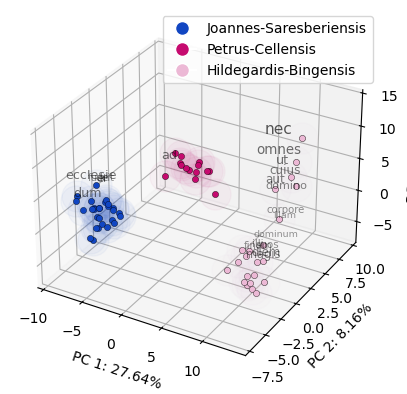

In [3]:
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler, FunctionTransformer, MinMaxScaler
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import random

pca = PCA(n_components=3)

X_bar = pca.fit_transform(X) # dimensionality reduction

# Extract the explained variance
var_exp = pca.explained_variance_ratio_
var_pc1 = np.round(var_exp[0]*100, decimals=2)
var_pc2 = np.round(var_exp[1]*100, decimals=2)
var_pc3 = np.round(var_exp[2]*100, decimals=2)
explained_variance = np.round(sum(pca.explained_variance_ratio_)*100, decimals=2)

loadings = pca.components_.transpose()
vocab_weights_p1 = sorted(zip(features, loadings[:,0]), key=lambda tup: tup[1], reverse=True)
vocab_weights_p2 = sorted(zip(features, loadings[:,1]), key=lambda tup: tup[1], reverse=True)
vocab_weights_p3 = sorted(zip(features, loadings[:,2]), key=lambda tup: tup[1], reverse=True)

# Make scatterplot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1, x2, x3 = X_bar[:,0], X_bar[:,1], X_bar[:,2]

# Plot loadings on top of figure

l1, l2, l3 = loadings[:,0], loadings[:,1], loadings[:,2]

scaler_one = MinMaxScaler(feature_range=(min(x1), max(x1)))
scaler_two = MinMaxScaler(feature_range=(min(x2), max(x2)))
scaler_three = MinMaxScaler(feature_range=(min(x3), max(x3)))

realigned_l1 = scaler_one.fit_transform(l1.reshape(-1, 1)).flatten()
realigned_l2 = scaler_two.fit_transform(l2.reshape(-1, 1)).flatten()
realigned_l3 = scaler_three.fit_transform(l3.reshape(-1, 1)).flatten()
    
# Makes the opacity of plotted features work
abs_l1 = np.abs(l1)
abs_l2 = np.abs(l2)
abs_l3 = np.abs(l3)
normalized_l1 = (abs_l1-min(abs_l1))/(max(abs_l1)-min(abs_l1))
normalized_l2 = (abs_l2-min(abs_l2))/(max(abs_l2)-min(abs_l2))
normalized_l3 = (abs_l3-min(abs_l3))/(max(abs_l3)-min(abs_l3))

normalized_vocab_weights_p1 = sorted(zip(features, normalized_l1), key=lambda tup: tup[1], reverse=True)
normalized_vocab_weights_p2 = sorted(zip(features, normalized_l2), key=lambda tup: tup[1], reverse=True)
normalized_vocab_weights_p3 = sorted(zip(features, normalized_l3), key=lambda tup: tup[1], reverse=True)

# Each feature's rank of importance on each of the PC's is calculated
# Normalized by importance of PC
d = {}
for (feat, weight) in normalized_vocab_weights_p1:
    d[feat] = []
for idx, (feat, weight) in enumerate(normalized_vocab_weights_p1):
    d[feat].append(idx * var_pc1)
for idx, (feat, weight) in enumerate(normalized_vocab_weights_p2):
    d[feat].append(idx * var_pc2)
for idx, (feat, weight) in enumerate(normalized_vocab_weights_p3):
    d[feat].append(idx * var_pc3)

n_top_discriminants = 20 # adjust to visualize fewer or more discriminants
best_discriminants = sorted([[feat, np.average(ranks)] for [feat, ranks] in d.items()], key = lambda x: x[1])
top_discriminants = [i[0] for i in best_discriminants][:n_top_discriminants]

# Function to generate a random color
def generate_random_color():
    return [random.random() for _ in range(3)]

# Scatterplot of datapoints

# Generate a random color for each author in the data set
color_dict = {author: None for author in set(authors)}
for author in color_dict.keys():
    color = generate_random_color()
    color_dict[author] = color

for index, (p1, p2, p3, a, title) in enumerate(zip(x1, x2, x3, authors, titles)):
    markersymbol = 'o'
    markersize = 20

    color = color_dict[a]
    full_title = title.split('_')[0]
    sample_number = title.split('_')[-1]

    # Uncomment for data points
    ax.scatter(p1, p2, p3, marker='o', color=color, s=markersize, zorder=3, alpha=1, edgecolors='k', linewidth=0.3)
    # Cloudy
    ax.scatter(p1, p2, p3, marker='o', color=color, s=500, zorder=1, alpha=0.03)

# Plot features
for x, y, z, opac_l1, opac_l2, opac_l3, feat, in zip(realigned_l1, realigned_l2, realigned_l3, normalized_l1, normalized_l2, normalized_l3, features):
    total_opac = (opac_l1 + opac_l2 + opac_l3)/3
    if feat in top_discriminants:
        ax.text(x, y, z, feat, color='k', ha='center', va="center", fontdict={'size': 17*total_opac}, zorder=10000, alpha=total_opac)

# Important to adjust margins first when function words fall outside plot
# This is due to the axes aligning (def align).
# ax2.margins(x=0.15, y=0.15)

ax.set_xlabel('PC 1: {}%'.format(var_pc1))
ax.set_ylabel('PC 2: {}%'.format(var_pc2))
ax.set_zlabel('PC 3: {}%'.format(var_pc3))

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=title) 
           for title, color in color_dict.items()]
ax.legend(handles=handles)

plt.show()

# Get the current time
current_time = datetime.now()
# Format the current time as a string
formatted_time = current_time.strftime("date %d-%m at %Hh%Mm")
fig.savefig(current_directory + '/output/pca-3D-{}.png'.format(current_time), dpi=300, transparent=True, format='png')

## 3.2 Dendrogram Analysis

Hierarchical clustering, also known as “agglomerative clustering”. 

The code and explanation below is cited from *Humanities Data Analysis: Case Studies with Python*, which "gives a practical guide to data-intensive humanities research using the Python programming language." The book is written by Folgert Karsdorp, Mike Kestemont and Allen Riddell, and is available as an Open Access interactive Jupyter Book here: https://www.humanitiesdataanalysis.org/stylometry/notebook.html .

"*This clustering method works bottom-up: it will first detect very low-level text clusters that are highly similar. These texts are then joined into clusters that eventually are merged with other clusters that have been detected. Such a model is often visualized using a tree-like graph or “dendrogram” (an example will be offered shortly), showing at which stages subsequent clusters have been merged in the procedure. As such, it offers an efficient visualization from which the main structure in a dataset becomes clear at a glance. Because of the tree-with-branches metaphor, this model is strongly hierarchical in nature.*" (M. Kestemont, [link](https://www.humanitiesdataanalysis.org/stylometry/notebook.html))

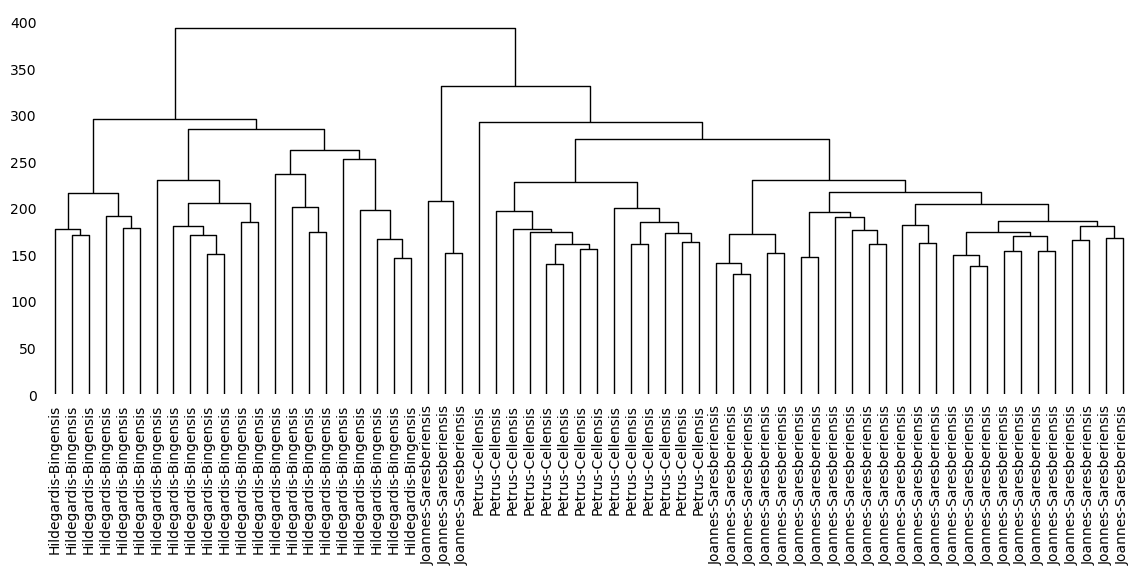

In [5]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance as scidist

# This code was written by Mike Kestemont
# see https://www.humanitiesdataanalysis.org/stylometry/notebook.html

# 1. Calculate pairwise distances
dm = scidist.pdist(X, 'cityblock')

# 2. Establish branch structure
linkage_object = hierarchy.linkage(dm, method='complete')

# 3. Visualize
def plot_tree(linkage_object, labels, figsize=(14, 5), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, labels=labels, ax=ax,
            link_color_func=lambda c: 'black',
            leaf_font_size=10, leaf_rotation=90)
    # Remove ticks and spines
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)
        
    # Get the current time
    current_time = datetime.now()
    # Format the current time as a string
    formatted_time = current_time.strftime("date %d-%m at %Hh%Mm")
    fig.savefig(current_directory + '/output/dendrogram-{}.png'.format(current_time), dpi=300, transparent=True, format='png')

plot_tree(linkage_object, authors)

"*The tree should be read from bottom to top, where the original texts are displayed as the tree’s leaf nodes. When moving to the top, we see how these original nodes are progressively being merged in new nodes by vertical branches. Subsequently, these newly created, non-original nodes are eventually joined into higher-level nodes and this process continues until all nodes have been merged into a single root node at the top. On the vertical axis, we see numbers which we can read as the distance between the various nodes: the longer the branches that lead up to a node, the more distant the nodes that are being merged.*" (M. Kestemont, [link](https://www.humanitiesdataanalysis.org/stylometry/notebook.html))

## 3.3 T-SNE

**T-SNE**, or t-distributed stochastic neighbor embedding, (Van der Maaten and Hinton, 2008), is a machine learning algorithm for non-linear dimensionality reduction, particularly well-suited for visualizing high-dimensional datasets.

Say we have a pair of vectors, representing respectively text segment A and text segment B. 

1. Firstly, t-SNE looks at how likely segment A is to be a neighbor of segment B in its **input space**, as we know by now, often a **high-dimensional space**: calculating the probability that two segments are neighbors is what is called a **joint probability**. Note that it is highly recommended to first use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the input dimensions to a reasonable number (e.g. 50) if that number is very high.
2. Consequently, t-SNE defines another set of probabilities for an **embedding space** or **lower-dimensional space**, often 2 or 3 dimensions.
3. Taking both sets of probabilities into account, t-SNE's main objective is to ensure that the lower-dimensional embedding **preserves** the pairwise relationships (joint probabilities) and complexities of the original or higher-dimensional data. It does so by minimizing the so-called Kullback-Leibler (KL) divergence between both sets of probabilities.  

As step 3 suggests, and as opposed to PCA, t-SNE has a (at times costly) learning process, with a number of **sensitive parameters** which heavily influence the resulting diagrammatic representation. In a way, the algorithm is 'smarter' than PCA, but also comes with configurable hyperparameters such as the **(1) perplexity**, **(2) learning rate**, and the **(3) number of iterations**, which need to be well understood.

1. Perplexity (`perp`) controls the trade-off between capturing both the local and global aspects of the corpus. Smaller `perp`-values focus more on capturing the local structure (more clusters), while larger values will take a broader view (fewer clusters). Typically, the values range between 5 and 50.
2. The learning rate (`lr`) controls the step size at each iteration: i.e. how much the algorithm should change the positions of the points per iteration. If it is too high, the data may become too spread out, and if it is too low, the data may become too compressed. Both situations can lead to poor representations. A common heuristic is to start with a learning rate between 10 and 1000. 
3. Number of Iterations (`n_iter`): number of times the algorithm updates the positions of the data points.

In summary, t-SNE is a powerful tool for reducing high-dimensional data to lower dimensions for visualization, but its effectiveness can be influenced significantly by the choice of hyperparameters. Perplexity, learning rate, and the number of iterations are crucial parameters that control the algorithm's behavior and the quality of the final embedding. Adjusting these parameters through experimentation and cross-validation is often necessary to obtain the best results for a given dataset.

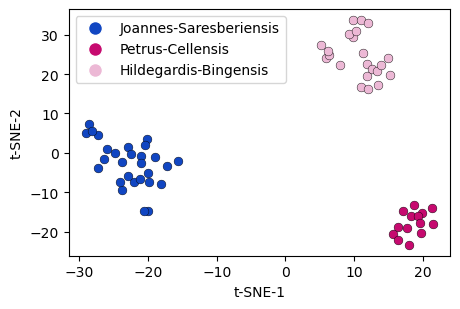

In [7]:
from sklearn.manifold import TSNE

# Parameters
lr = 10 # learning rate (steps) per iteration
n_iter = 1000 # number of iterations
perp = 5 # perplexity

pca = PCA(n_components=50)
pca_X = pca.fit_transform(X)
tsne = TSNE(n_components=2, perplexity=perp, learning_rate=lr, n_iter=n_iter)
tsne_X = tsne.fit_transform(pca_X)

fig = plt.figure(figsize=(4.7,3.2))
ax = fig.add_subplot(111)
x1, x2  =  tsne_X[:,0], tsne_X[:,1]

for index, (p1, p2, a, title) in enumerate(zip(x1, x2, authors, titles)):
    ax.scatter(p1, p2, marker='o', color=color_dict[a], s=40, edgecolors ='k', linewidths=0.3)

    ax.set_xlabel('t-SNE-1')
    ax.set_ylabel('t-SNE-2')

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=title) 
           for title, color in color_dict.items()]
ax.legend(handles=handles)

plt.tight_layout()
plt.show()

# Get the current time
current_time = datetime.now()
# Format the current time as a string
formatted_time = current_time.strftime("date %d-%m at %Hh%Mm")
fig.savefig(current_directory + '/output/tsne-{}.png'.format(current_time), dpi=300, transparent=True, format='png')